# Modelling liquid-line-of-descents

- One of the primary uses of the MELTS thermodynamic models is simulating the crystallization of magma under different conditions.
- This can be useful for identifying whether samples are linked by crystallisation or if other processes are required to explain the geochemical variability of a region.

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files. Please see the installation guide on ReadTheDocs.

Data used in the calculations below can be downloaded from here: https://github.com/gleesonm1/PetThermoTools/blob/master/docs/Examples/CrystallisationTests/Fernandina_glass.xlsx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
# import sys
# sys.path.append(r'C:\Users\penny\Box\Berkeley_new\MELTS_Installation\alphamelts_py\alphamelts-py-2.3.1-win64')

# Now run this and itll check you have added it properly
import petthermotools as ptt

In [3]:
# Should be used to suppress outputs on MacOS - run twice
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

In this notebook we'll show how PetThermoTools can quickly perform multiple calculations (utilizing parallel processing), and investigate how the liquid-line-of-descent is linked to the conditions of magma storage.

First, we need to load in some data. For this example we'll use data from Isla Fernandina in the Galapagos Archipelago, where a series of melt inclusions (Koleszar et al. 2009) and matrix glasses (Peterson et al. 2017) provide us with plenty of glass data to constain the magmatic evolution of the sub-volcanic system. The melt inclusion and matrix glass data is included in a single excel spreadsheet that we can load in using Pandas. We can also split this DataFrame into two. One containing just the melt inclusion data, the second including just the matrix glass data.

In [4]:
df = pd.read_excel('Fernandina_glass.xlsx')
df = df.fillna(0)

# split data based on the Group (Melt Inclusion or Matrix Glass)
MI = df.loc[df['Group'] == 'MI',:].reset_index(drop = True)
MG = df.loc[df['Group'] == 'MG',:].reset_index(drop = True)

MG.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MG,-0.17,-91.77,49.11,2.90,14.04,11.38,0.21,6.53,11.88,2.55,0.43,0.30,0.593,0.011442
1,MG,-0.17,-91.77,49.22,3.10,14.09,11.37,0.20,6.75,11.78,2.75,0.44,0.31,0.683,0.009890
2,MG,-0.21,-91.81,49.01,2.92,13.92,11.74,0.21,6.31,11.90,2.55,0.46,0.33,0.635,0.012210
3,MG,-0.21,-91.80,49.42,3.14,13.92,11.77,0.20,6.47,11.46,2.82,0.46,0.33,0.732,0.010531
4,MG,-0.24,-91.75,48.76,3.57,13.88,11.83,0.23,6.37,11.40,3.09,0.52,0.36,0.834,0.007797


One of the key things that we need to perform any calculations with MELTS is a starting composition. To start, let's use the most primitive (highest MgO) composition from the melt inclusion analyses. There are a few ways to find this composition, the way I like to do so (not necessarily the quickest) is to simply sort the melt inclusion DataFrame by the MgO contents and select the first row:

In [5]:
MI = MI.sort_values('MgO', ascending = False, ignore_index = True)
MI.head()

,Group,Latitude,Longitude,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,P2O5,H2O,CO2
0,MI,0.0,0.0,47.5,2.29,16.4,9.16,0.123,9.38,11.6,2.25,0.329,0.257,0.68,0.0280
1,MI,0.0,0.0,47.5,2.58,15.5,10.04,0.138,8.97,11.4,2.44,0.428,0.262,0.69,0.0630
2,MI,0.0,0.0,49.2,2.33,16.0,8.67,0.147,8.94,12.0,1.78,0.005,0.094,0.78,0.0004
3,MI,0.0,0.0,48.4,2.50,15.7,9.07,0.139,8.88,11.6,2.18,0.398,0.326,0.69,0.0126
4,MI,0.0,0.0,48.1,2.46,15.3,8.96,0.153,8.82,12.1,2.34,0.325,0.387,0.88,0.4986


In [6]:
starting_comp = MI.loc[0]
starting_comp

Group           MI
Latitude       0.0
Longitude      0.0
SiO2          47.5
TiO2          2.29
Al2O3         16.4
FeOt          9.16
MnO          0.123
MgO           9.38
CaO           11.6
Na2O          2.25
K2O          0.329
P2O5         0.257
H2O           0.68
CO2          0.028
Name: 0, dtype: object

We can now perform crystallisation calculations. These calculations are run using rhyoliteMELTSv1.2.0 (we have some CO$_2$ in the starting composition), start at the liquidus and end at 1100$^o$C. The calculations are also run at 1 log unit below the FMQ buffer. By specifying Frac_solid = True, we inform PetThermoTools that we want to perform a fractional (rather than equilibrium) crystallisation scenario.

In [7]:
Isobaric_Xtal = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
                                           bulk = starting_comp,
                                           find_liquidus = True,
                                           P_bar = [500,1000,2000,4000],
                                           T_end_C = 1100,
                                           dt_C = 2,
                                           fO2_buffer = "FMQ",
                                           fO2_offset = -1.0,
                                           Frac_solid = True,
                                           Frac_fluid = True,
                                           label = "P_bar")

This code will perform all 4 calculations at the specified pressures simultaneously. This 'parallel processing' significantly reduces the time required to perform these models.

There are several ways to display the results. Option 1 is to use the in-built harker plotting function which directly creates oxide-oxide plots without having to make any changes to the output from the crystallisation models. You'll see below that the code also allows other data to be loaded and plotted alongside the models: 

(<Figure size 960x900 with 9 Axes>,
 array([[<Axes: xlabel='MgO', ylabel='SiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='TiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='Al$_2$O$_3$'>],
        [<Axes: xlabel='MgO', ylabel='FeO$_t$'>,
         <Axes: xlabel='MgO', ylabel='CaO'>,
         <Axes: xlabel='MgO', ylabel='Na$_2$O'>],
        [<Axes: xlabel='MgO', ylabel='K$_2$O'>, <Axes: >, <Axes: >]],
       dtype=object))

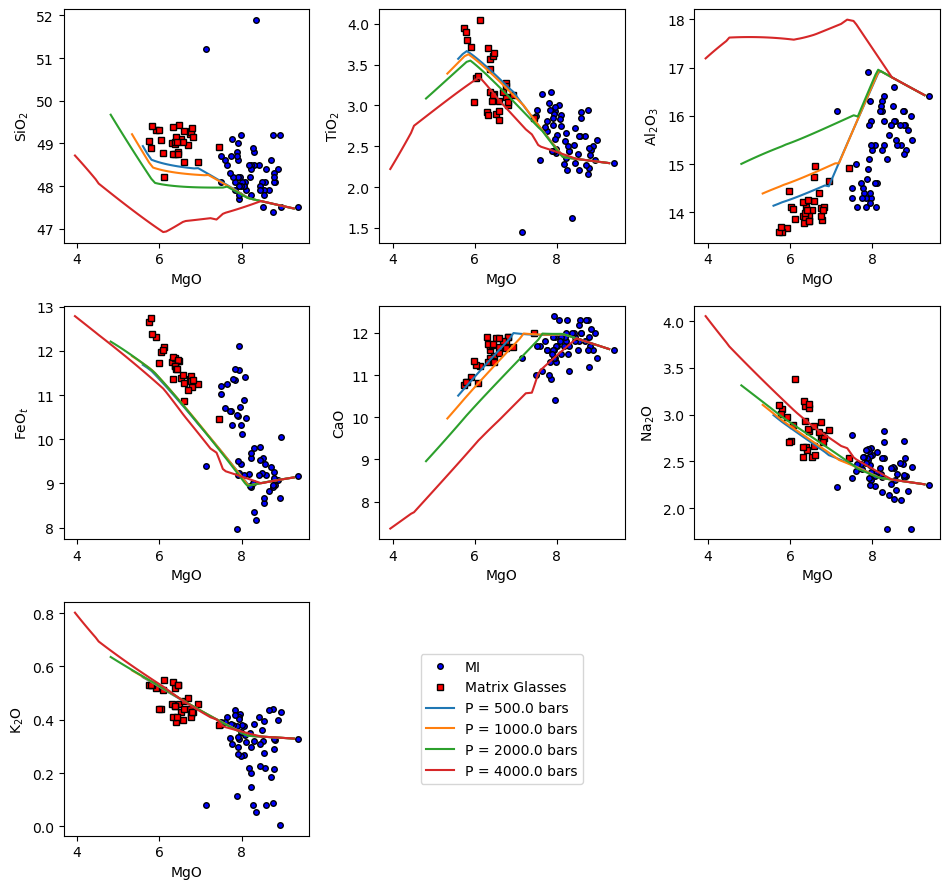

In [8]:
ptt.harker(Results = Isobaric_Xtal, data = {'MI': MI, 'Matrix Glasses': MG},
    d_color = ['b','red'], legend = [1,2])

We can also use the in-built function `phase_plot` to examine the phase proportions at each step of the crystallization model.

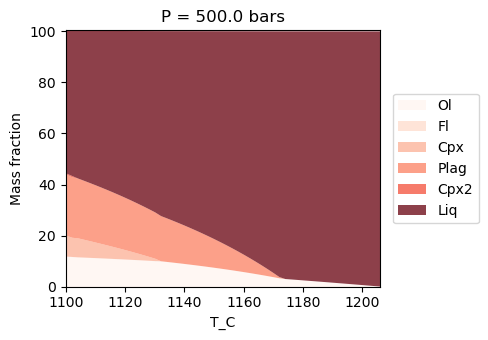

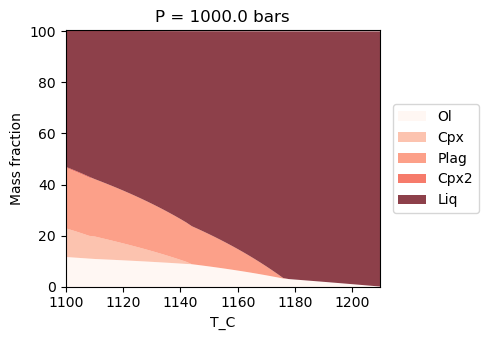

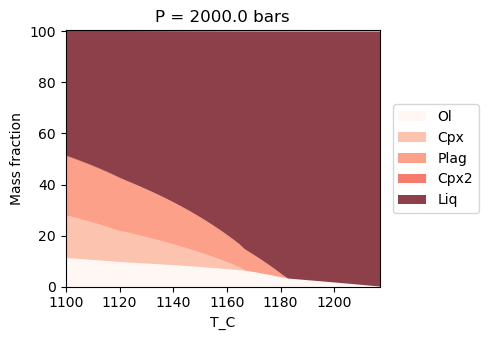

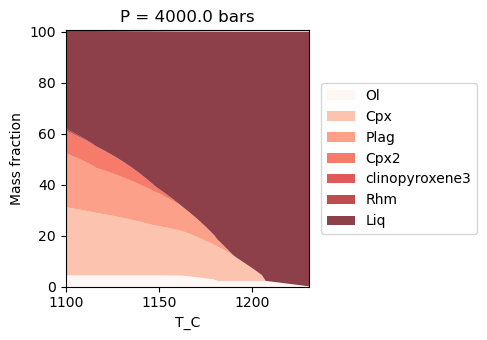

In [9]:
f, a = ptt.phase_plot(Isobaric_Xtal, x_axis = 'T_C', 
                       cmap = "Reds")

We can see that the lower pressure models generally provide a better fit to the Data. Also, examining the results would reveal that as pressure decreases, clinopyroxene stability decreases (it saturates at lower MgO contents) as would be expected based on experimental data.

There are, however, several other variables that we haven't explored in these models above that might influence our results. To demonstrate this, let's change the melt H$_2$O and CO$_2$ contents and re-run the models.

Gleeson et al. (2022) suggest that the melt inclusion H$_2$O contents measured by Koleszar et al. (2009) overpredict the melt H$_2$O content at the time of melt inclusion formation. In addition, the melt CO$_2$ content was likely underestimated as the CO$_2$ content in melt inclusions from Fernandinas reaches up to around 5000 ppm. Therefore, let's use these values to see how changing melt H$_2$O and CO$_2$ contents influences the liquid line of descent. There is no need to change our starting composition, we can simply use the H2O_Liq and CO2_Liq inputs in the isobaric_crystallisation function to 'overwrite' the initial H$_2$O and CO$_2$ contents of the magma.

In [10]:
Isobaric_Xtal_CO2 = ptt.isobaric_crystallisation(Model = "MELTSv1.2.0",
    bulk=starting_comp,find_liquidus=True,P_bar=np.array([500,1000,2000,4000]),
    T_end_C=1050,dt_C=2,fO2_buffer="FMQ",fO2_offset=-1.0,
    Frac_solid=True,Frac_fluid=True,H2O_init=0.4,CO2_init=0.5,label="P_bar")

(<Figure size 960x600 with 6 Axes>,
 array([[<Axes: xlabel='MgO', ylabel='SiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='TiO$_2$'>,
         <Axes: xlabel='MgO', ylabel='Al$_2$O$_3$'>],
        [<Axes: xlabel='MgO', ylabel='FeO$_t$'>,
         <Axes: xlabel='MgO', ylabel='CaO'>,
         <Axes: xlabel='MgO', ylabel='Na$_2$O'>]], dtype=object))

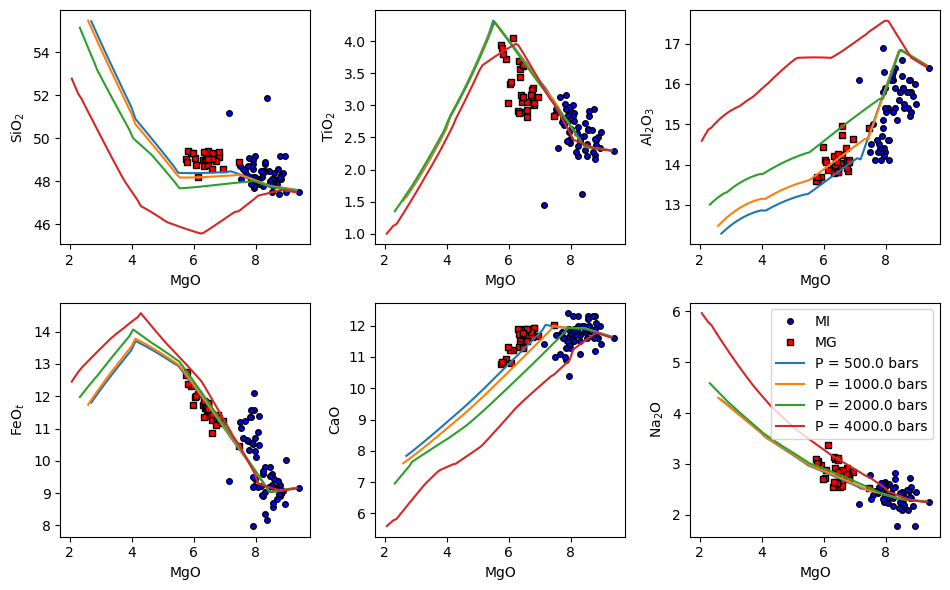

In [11]:
ptt.harker(Results = Isobaric_Xtal_CO2, data = {'MI': MI, 'MG': MG},
    d_color = ['b','red'], legend_loc = [1,2], 
    y_axis = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'CaO', 'Na2O'])

We can see that making this change has improved the fit between models and data (for some oxide pairs).

It is also possible to integrate the results with pyrolite (Williams et al. 2020) to plot the results of the models on a TAS diagram:

In [12]:
# If you have not installed pyrolite already, you need to comment out the # in the line below and install it now. Once you've run thisonce, 
# you can re-comment it out again. 

#!pip install pyrolite

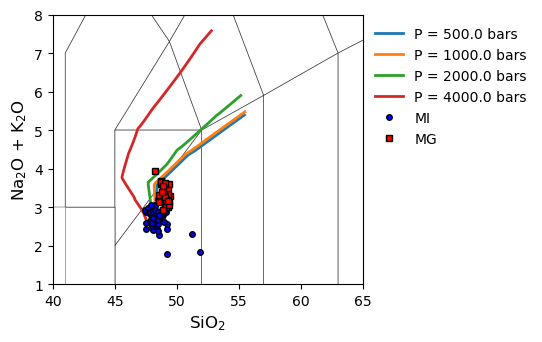

In [13]:
# ---- Create TAS diagram from pyrolite ----
from pyrolite.util.classification import TAS
cm = TAS()
f, a = plt.subplots(1,1, figsize=(4,3.5))
cm.add_to_axes(a,alpha=0.5,linewidth=0.5,
    zorder=-1,add_labels=False)

# ---- Loop through model results ----
for i in Isobaric_Xtal_CO2:
    df = Isobaric_Xtal_CO2[i]['All'].copy()
    df['Na2O+K2O']=df['Na2O_Liq']+df['K2O_Liq']
    a.plot(df['SiO2_Liq'],df['Na2O+K2O'], lw = 2,
        linestyle='-',alpha=1, label = i)

# ---- Plot glass data ----
a.plot(MI['SiO2'],MI['Na2O']+MI['K2O'],
    'ok', mfc = 'b', label="MI")
a.plot(MG['SiO2'],MG['Na2O']+MG['K2O'],
    'sk', mfc = 'r', label="MG")

a.set_xlim([40, 65])
a.set_ylim([1, 8])
a.legend()
    

We can also use Thermobar (Wieser et al. 2022) to examine mineral compositions using the clinopyroxene quadrilateral.

In [14]:
# If you have not installed Thermobar already, you need to comment out the # in the line below and install it now. Once you've run thisonce, 
# you can re-comment it out again. 


# !pip install Thermobar

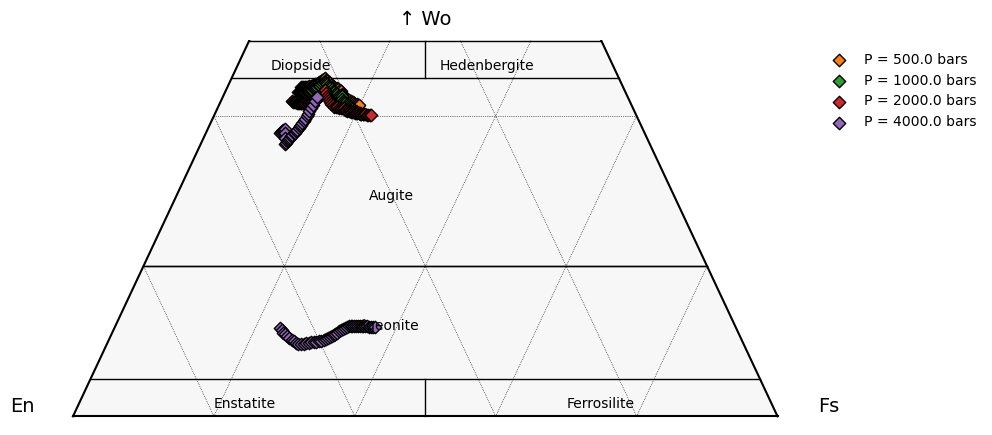

In [15]:
import Thermobar as pt
f, tax = pt.plot_px_classification(figsize = (10,5),major_grid = True, labels = True)
for i in Isobaric_Xtal_CO2.keys():   
    cpx_comps_tern_1 = pt.tern_points_px(px_comps = Isobaric_Xtal_CO2[i]['clinopyroxene1'])
    tax.scatter(cpx_comps_tern_1,edgecolor = 'k',  s = 40, label = i) #If you want points. 
     
tax.legend()